In [2]:
!pip install tensorflow-addons


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible.
ydata-profiling 4.9.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import tensorflow as tf
import os

# Directory paths
monet_jpg_dir = '/kaggle/input/gan-getting-started/monet_jpg'
monet_tfrec_dir = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_jpg_dir = '/kaggle/input/gan-getting-started/photo_jpg'
photo_tfrec_dir = '/kaggle/input/gan-getting-started/photo_tfrec'

# Load .jpg files from directories
monet_jpg_files = [os.path.join(monet_jpg_dir, fname) for fname in os.listdir(monet_jpg_dir) if fname.endswith('.jpg')]
photo_jpg_files = [os.path.join(photo_jpg_dir, fname) for fname in os.listdir(photo_jpg_dir) if fname.endswith('.jpg')]

# Load .tfrec files from directories
monet_tfrec_files = [os.path.join(monet_tfrec_dir, fname) for fname in os.listdir(monet_tfrec_dir) if fname.endswith('.tfrec')]
photo_tfrec_files = [os.path.join(photo_tfrec_dir, fname) for fname in os.listdir(photo_tfrec_dir) if fname.endswith('.tfrec')]

# Print out the number of files loaded
print(f"Loaded {len(monet_jpg_files)} Monet jpg files.")
print(f"Loaded {len(photo_jpg_files)} Photo jpg files.")
print(f"Loaded {len(monet_tfrec_files)} Monet tfrec files.")
print(f"Loaded {len(photo_tfrec_files)} Photo tfrec files.")


Loaded 300 Monet jpg files.
Loaded 7038 Photo jpg files.
Loaded 5 Monet tfrec files.
Loaded 20 Photo tfrec files.


Displaying 2 Monet JPG sample images:
Image: /kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
Size: (256, 256)
Mode: RGB


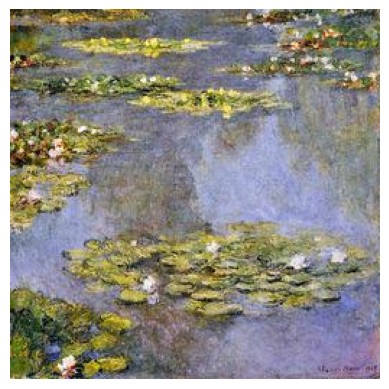

Image: /kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
Size: (256, 256)
Mode: RGB


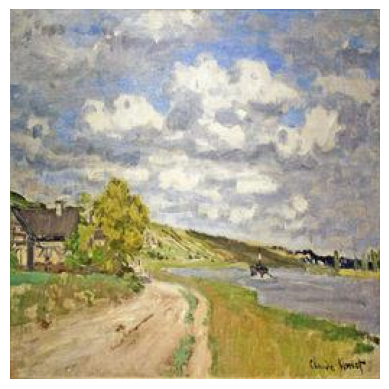

In [4]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load and inspect a random image from each dataset
def inspect_image(file_path):
    img = Image.open(file_path)
    print(f"Image: {file_path}")
    print(f"Size: {img.size}")  # (width, height)
    print(f"Mode: {img.mode}")  # RGB, Grayscale, etc.
    return img

# Display 5 sample images from Monet jpg
sample_monet_jpg = monet_jpg_files[:2]
print(f"Displaying {len(sample_monet_jpg)} Monet JPG sample images:")
for image_path in sample_monet_jpg:
    img = inspect_image(image_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Displaying 2 Photo JPG sample images:
Image: /kaggle/input/gan-getting-started/photo_jpg/fb97febc5f.jpg
Size: (256, 256)
Mode: RGB


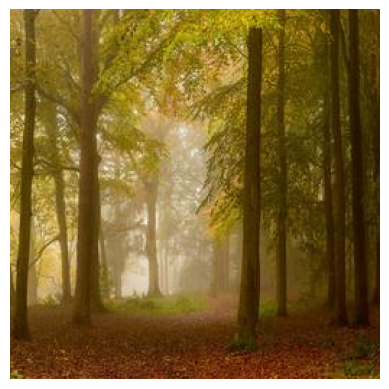

Image: /kaggle/input/gan-getting-started/photo_jpg/c54c5368af.jpg
Size: (256, 256)
Mode: RGB


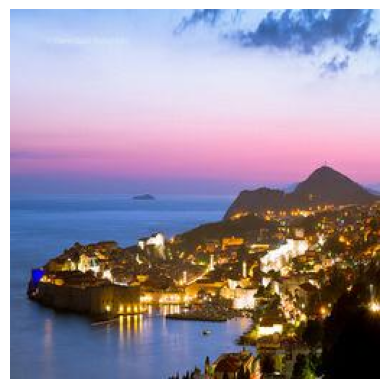

In [5]:

# Display 5 sample images from Photo jpg
sample_photo_jpg = photo_jpg_files[:2]
print(f"Displaying {len(sample_photo_jpg)} Photo JPG sample images:")
for image_path in sample_photo_jpg:
    img = inspect_image(image_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Inspecting Monet TFRecord files:


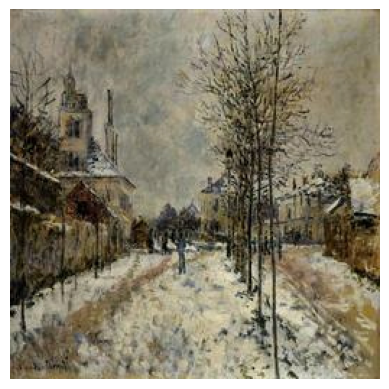

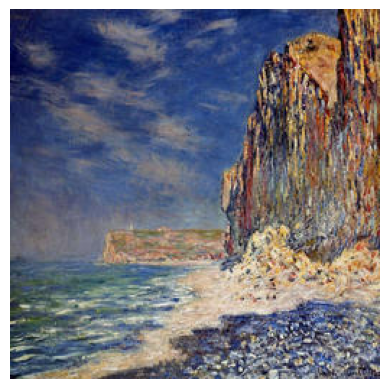

In [6]:
def parse_tfrecord_fn(example):
    # Update the feature description to use the correct key "image"
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # The image data is stored as raw bytes
        # You can add other features if needed, but for now, we're only working with the image
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image from the raw bytes
    image = tf.image.decode_jpeg(example['image'], channels=3)
    
    return image

# Function to load and display images from a TFRecord file
def inspect_tfrec(tfrec_file):
    raw_image_dataset = tf.data.TFRecordDataset(tfrec_file)
    parsed_image_dataset = raw_image_dataset.map(parse_tfrecord_fn)
    
    # Visualize 5 images
    for image in parsed_image_dataset.take(2):
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Now we can inspect the Monet TFRecord file again
print("Inspecting Monet TFRecord files:")
inspect_tfrec(monet_tfrec_files[0])


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import shutil


In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.LayerNormalization())  # Changed to LayerNormalization

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.LayerNormalization())  # Changed to LayerNormalization

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


In [10]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = layers.LayerNormalization()(conv)  # LayerNormalization instead of InstanceNormalization
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [12]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo -> monet -> photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet -> photo -> monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # identity
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle losses
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Identity losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }


In [13]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


In [14]:
monet_generator = Generator()  # Monet-style generator
photo_generator = Generator()  # Photo-style generator
monet_discriminator = Discriminator()  # Monet discriminator
photo_discriminator = Discriminator()  # Photo discriminator

monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)


In [15]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_monet(image_file):
    return load_image(image_file)

def load_photo(image_file):
    return load_image(image_file)

# Convert .jpg file paths to a TensorFlow dataset
monet_ds = tf.data.Dataset.from_tensor_slices(monet_jpg_files)
monet_ds = monet_ds.map(load_monet, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

photo_ds = tf.data.Dataset.from_tensor_slices(photo_jpg_files)
photo_ds = photo_ds.map(load_photo, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)


In [16]:
# Train the CycleGAN model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)


Epoch 1/25


I0000 00:00:1726430310.448639     125 service.cc:145] XLA service 0x78223c002760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726430310.448691     125 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726430379.569981     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1726430379.688891     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 163s 149ms/step - monet_disc_loss: 0.8164 - monet_gen_loss: 5.5517 - photo_disc_loss: 0.9034 - photo_gen_loss: 5.6434
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_loss: 0.6956 - monet_gen_loss: 3.7002 - photo_disc_loss: 0.6954 - photo_gen_loss: 3.7564
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_loss: 0.6793 - monet_gen_loss: 3.2000 - photo_disc_loss: 0.6795 - photo_gen_loss: 3.2595
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_loss: 0.6650 - monet_gen_loss: 2.9498 - photo_disc_loss: 0.6736 - photo_gen_loss: 3.0033
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_loss: 0.6615 - monet_gen_loss: 2.8253 - photo_disc_loss: 0.6702 - photo_gen_loss: 2.8383
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_loss: 0.6609 - monet_gen_loss: 2.6973 - photo_disc_loss: 0.6696 - photo_gen_loss: 2.7001
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - monet_disc_

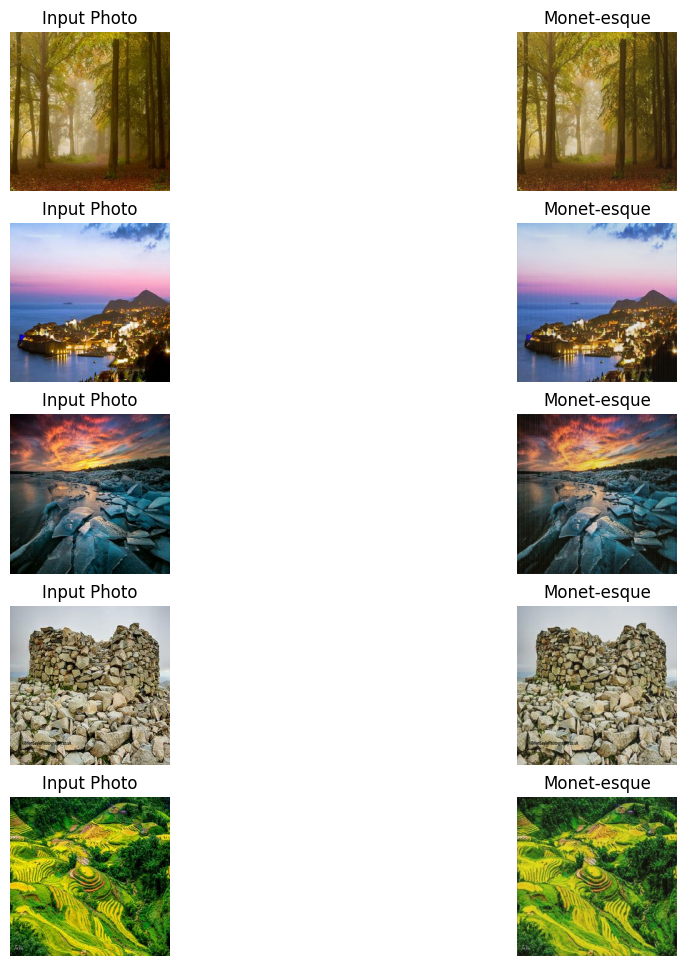

In [18]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))

for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # De-normalize the generated image
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)  # De-normalize the input photo

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()


In [17]:
import PIL

# Create a directory to save the generated images
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # De-normalize to [0, 255]
    im = PIL.Image.fromarray(prediction)
    im.save(f"../images/{i}.jpg")
    i += 1

# Compress the images into a zip file for submission
shutil.make_archive("/kaggle/working/images", 'zip', "../images")


'/kaggle/working/images.zip'

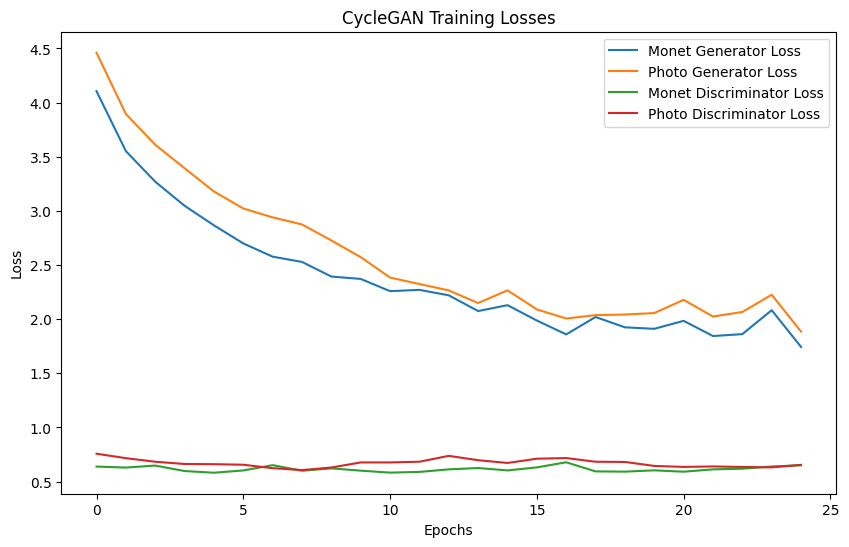

In [19]:
# Get the history object
history = cycle_gan_model.history

# Extract loss values
monet_gen_loss = history.history['monet_gen_loss']
photo_gen_loss = history.history['photo_gen_loss']
monet_disc_loss = history.history['monet_disc_loss']
photo_disc_loss = history.history['photo_disc_loss']

# Plot generator and discriminator losses over epochs
plt.figure(figsize=(10, 6))

plt.plot(monet_gen_loss, label='Monet Generator Loss')
plt.plot(photo_gen_loss, label='Photo Generator Loss')
plt.plot(monet_disc_loss, label='Monet Discriminator Loss')
plt.plot(photo_disc_loss, label='Photo Discriminator Loss')

plt.title('CycleGAN Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
